In [18]:
import numpy as np
import matplotlib.pyplot as plt
from reactionmodel.model import Species, Reaction, Model

In [19]:
S1 = Species('S1')
S2 = Species('S2')
T  = Species('T')

In [20]:
l = 1.0
u = 1.0001
birth = Reaction([S1], [(S1, 2)], description='birth', k=l)
death = Reaction([S1], [], description='death', k=u)
m = Model([S1], [birth, death])

In [21]:
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

hybrid_simulator = HybridSimulator(
    k=m.get_k(jit=True),
    N=m.stoichiometry(),
    kinetic_order_matrix=m.kinetic_order(),
    partition_function=FixedThresholdPartitioner(1000).partition_function,
)

In [22]:
result = hybrid_simulator.simulate(
    (0.0, 100.0),
    [10.0],
    rng = np.random.default_rng(),
)

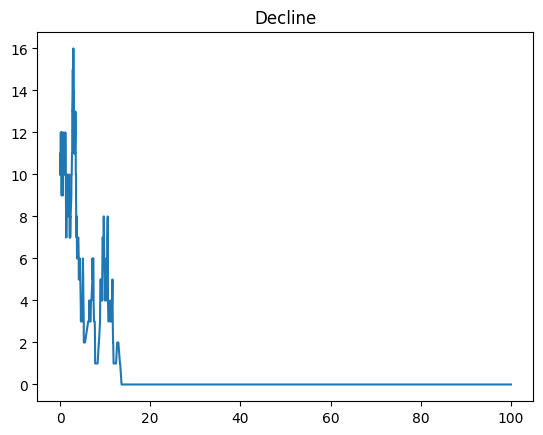

In [23]:
plt.plot(result.t_history, result.y_history[0,:].T)
plt.title("Decline")
plt.show()

# Pure Gillespie

In [34]:
from hybrid.gillespie import GillespieSimulator

g_simulator = GillespieSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    jit=True,
)

In [35]:
result = g_simulator.simulate(
    (0.0, 100.0),
    [1000.0],
    rng = np.random.default_rng(),
)

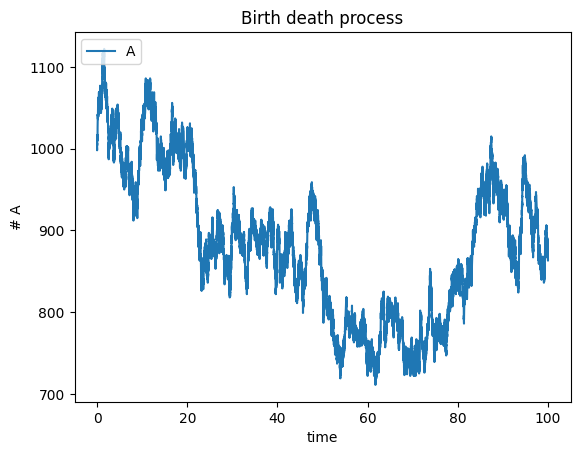

In [36]:
plt.plot(result.t_history, result.y_history.T)
plt.title("Birth death process")
plt.legend(['A'], loc='upper left')
plt.xlabel('time')
plt.ylabel('# A')
plt.savefig('birthdeath.png', bbox_inches='tight', dpi=200)
plt.show()


# Tau leaping

In [37]:
from hybrid.tau import TauLeapSimulator

t_simulator = TauLeapSimulator(
    m.get_k(jit=True),
    m.stoichiometry(),
    m.kinetic_order(),
    jit=True,
)

In [38]:
result = t_simulator.simulate(
    (0.0, 100.0),
    [1000.0],
    rng = np.random.default_rng(),
)

/Users/thayer/develop/hybrid/hybrid/gillespie.py:63: RuntimeWarning: divide by zero encountered in scalar divide
  hitting_time = hitting_point / total_propensity


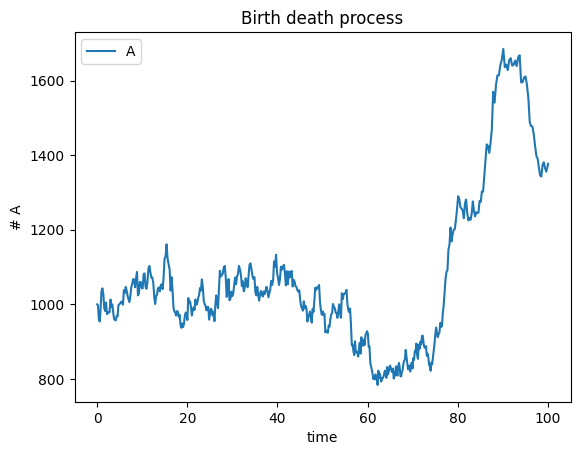

In [39]:
plt.plot(result.t_history, result.y_history.T)
plt.title("Birth death process")
plt.legend(['A'], loc='upper left')
plt.xlabel('time')
plt.ylabel('# A')
plt.savefig('birthdeath.png', bbox_inches='tight', dpi=200)
plt.show()

# Crystallization

In [12]:
import numpy as np
from hybrid.hybrid import HybridSimulator, FixedThresholdPartitioner

k = np.array([1e-7, 1e-7])

N = np.array([ # A, B, C, D
    [-2, 1, 0, 0],
    [-1, 0, -1, 1],
]).T.astype(float)

kinetic_orders = np.array([
    [2, 0, 0, 0],
    [1, 0, 1, 0]
]).T.astype(float)


simulator = HybridSimulator(k, N, kinetic_orders, partition_function=FixedThresholdPartitioner(100.0), jit=True)

result = simulator.simulate(
    t_span = (0.0, 100.0),
    y0 = [1e6, 0, 10, 0],
    rng = np.random.default_rng(),
)

In [13]:
result.y

array([9.09490e+04, 4.54521e+05, 0.00000e+00, 1.00000e+01])

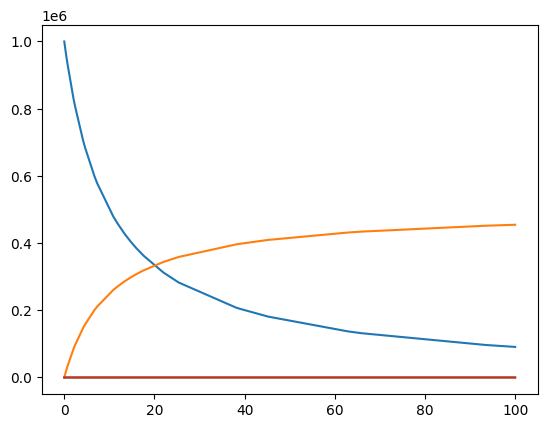

In [14]:
#for i in range(N.shape[1]):
plt.plot(result.t_history, result.y_history.T)

# Lotka-Volterra

Evaluating expression: alpha => 1.1
Evaluating expression: beta => 0.4
Evaluating expression: delta => 0.1
Evaluating expression: gamma => 0.4


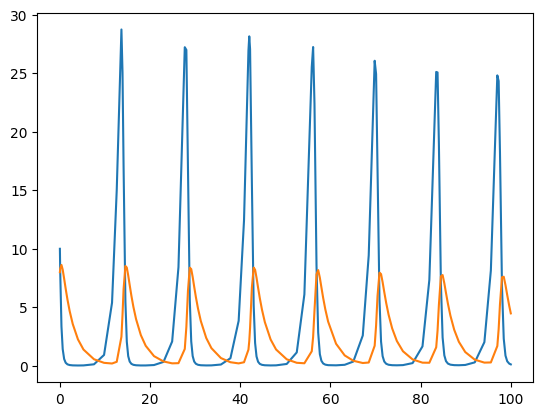

In [15]:
import scipy.integrate
import matplotlib.pyplot as plt
from reactionmodel.model import Species, Model, Reaction

prey = Species('Prey')
predator = Species('Predator')

reactions = []
reactions.append(Reaction([prey], [(prey, 2)], k="alpha", description="prey birth"))
reactions.append(Reaction([prey, predator], [predator], k="beta", description="prey death"))
reactions.append(Reaction([predator, prey], [(predator, 2)], k="delta", description="predator birth"))
reactions.append(Reaction([predator], [], k="gamma", description="predator death"))

m = Model([prey, predator], reactions)

parameters = {
    'alpha': 1.1,
    'beta': 0.4,
    'delta': 0.1,
    'gamma': 0.4
}

dydt = m.get_dydt(parameters=parameters)
result = scipy.integrate.solve_ivp(dydt, [0.0, 100.0], y0=[10.0, 8.0])
plt.plot(result.t, result.y.T)

Evaluating expression: alpha => 1.1
Evaluating expression: beta => 0.4
Evaluating expression: delta => 0.1
Evaluating expression: gamma => 0.4


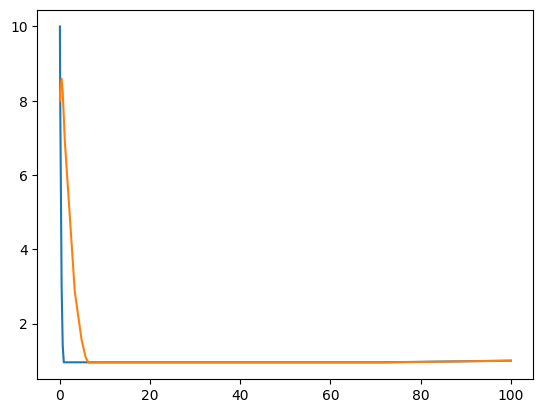

In [16]:
parameters = {
    'alpha': 1.1,
    'beta': 0.4,
    'delta': 0.1,
    'gamma': 0.4
}

simulator = m.get_simulator(HybridSimulator, partition_function=FixedThresholdPartitioner(0.), parameters=parameters)

rng = np.random.default_rng()
result = simulator.simulate([0.0, 100.0], [10.0, 8.0], rng)

plt.plot(result.t_history, result.y_history.T)

In [17]:
1e6 - 10**6

0.0